## Quality Processes for Videos

In [7]:
# Importing useful dependencies
import io
import os
import boto3
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

In [8]:
# Setup S3 client for MinIO (MinIO implements Amazon S3 API)
s3 = boto3.client(
    "s3",
    endpoint_url="http://localhost:9000", # MinIO API endpoint
    aws_access_key_id="minioadmin", # User name
    aws_secret_access_key="minioadmin", # Password
)

Before preparing/cleaning the data for exploitation zone, we have to perform a quality analysis of the videos stored in the Trusted Zone (Copied from the Formatted Zone). For that purpose, firstly we are going to extract data from each of our videos.

In [9]:
# Given a bucket and a prefix, the function returns a list of data of each video in the target path
def get_data_videos(bucket, prefix=""):

    data = []
    
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            
            key = obj["Key"]

            if obj['Size'] == 0 and key.endswith("/"): # skip the folder itself
                continue

            # Download the video
            resp = s3.get_object(Bucket=bucket, Key=key)
            body = resp["Body"].read()

            # Use a temporary file to read the video with OpenCV
            with open("temp_video_in.mp4", "wb") as f:
                f.write(body)

            cv2.VideoCapture()

            cap = cv2.VideoCapture("temp_video_in.mp4")
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
            ret, frame = cap.read()
            if ret:
                n_channels = frame.shape[2] if len(frame.shape) == 3 else 1
                mode = 'BGR' if n_channels == 3 else 'GRAY'
            else:
                n_channels = 0
                mode = "N/A"

            cap.release()
            os.remove("temp_video_in.mp4")

            data.append({
                "file_name": key,
                "file_size": obj['Size'] / 1024, # B -> KB
                "width": width,
                "height": height,
                "aspect_ratio": round(width/height, 2) if height > 0 else None,
                "mode": mode,
                "channels": n_channels
            })

    return data

In [10]:
# Get data from the bucket
data = get_data_videos(bucket = "trusted-zone", prefix = "videos")

In [11]:
# Convert the data into a dataFrame
df_data = pd.DataFrame(data)
df_data.head()

,file_name,file_size,width,height,aspect_ratio,mode,channels
0,videos/video_1760786503181.mp4,32733.104492,1280,720,1.78,BGR,3
1,videos/video_1760786503789.mp4,68250.538086,1920,1080,1.78,BGR,3
2,videos/video_1760786504973.mp4,57138.572266,1920,1080,1.78,BGR,3
3,videos/video_1760786506567.mp4,35187.255859,1920,1080,1.78,BGR,3
4,videos/video_1760786507389.mp4,16812.027344,1920,1080,1.78,BGR,3


In [12]:
# Have a quick summary of the data
df_data.describe(include="all")

,file_name,file_size,width,height,aspect_ratio,mode,channels
count,29,29.000000,29.000000,29.000000,29.000000,29,29.0
unique,29,NaN,NaN,NaN,NaN,1,NaN
top,videos/video_1760786503181.mp4,NaN,NaN,NaN,NaN,BGR,NaN
freq,1,NaN,NaN,NaN,NaN,29,NaN
mean,NaN,41393.089440,1677.241379,947.448276,1.764828,NaN,3.0
std,NaN,21712.873311,359.353552,190.840918,0.083650,NaN,0.0
min,NaN,9476.816406,640.000000,480.000000,1.330000,NaN,3.0
25%,NaN,22799.700195,1280.000000,720.000000,1.780000,NaN,3.0
50%,NaN,37329.501953,1920.000000,1080.000000,1.780000,NaN,3.0
75%,NaN,57138.572266,1920.000000,1080.000000,1.780000,NaN,3.0


In [13]:
# Unique values for mode
pd.unique(df_data['mode'])

array(['BGR'], dtype=object)

-- Comment

**Distribution of File Sizes**

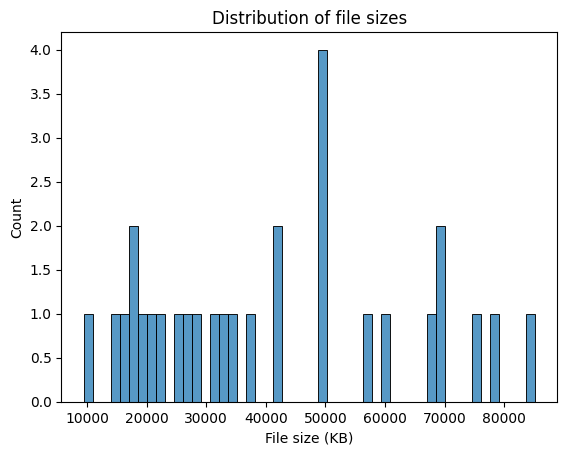

In [14]:
sns.histplot(df_data["file_size"], bins=50)
plt.xlabel("File size (KB)")
plt.ylabel("Count")
plt.title("Distribution of file sizes")
plt.show()

-- Comment outliers

**Width vs Height of Videos**

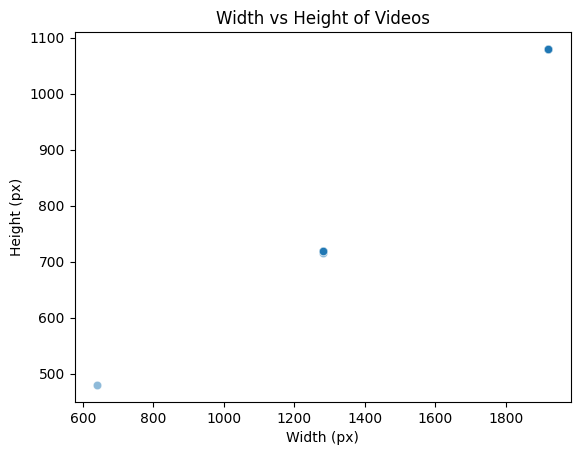

In [15]:
sns.scatterplot(x="width", y="height", data=df_data, alpha=0.5)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Width vs Height of Videos")
plt.show()

-- Comment

**Aspect Ratio Distribution**

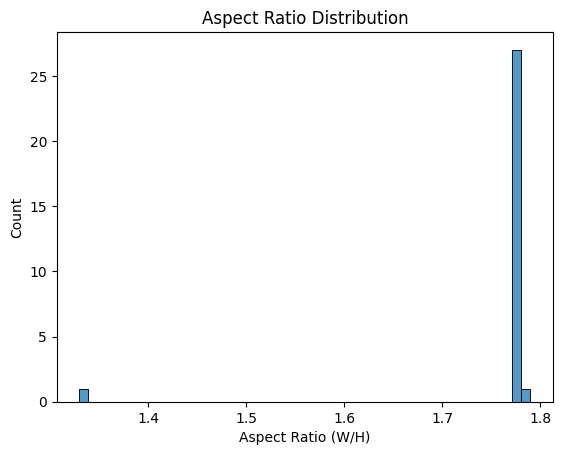

In [16]:
sns.histplot(df_data["aspect_ratio"].dropna(), bins=50)
plt.xlabel("Aspect Ratio (W/H)")
plt.title("Aspect Ratio Distribution")
plt.show()

**Data Cleaning**

In [17]:
def preprocess_video(bucket, prefix="", target_fps = 30, target_size=(512, 512), segment_minutes = 5):
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            key = obj["Key"]

            if obj['Size'] == 0 and key.endswith("/"): # skip the folder itself
                continue
            
            # Get object metadata to check size
            head = s3.head_object(Bucket=bucket, Key=key)
            if head['ContentLength'] == 0:
                # Delete the null video (size = 0)
                s3.delete_object(Bucket=bucket, Key=key)
                continue

            # Download the video
            resp = s3.get_object(Bucket=bucket, Key=key)
            body = resp["Body"].read()
            
            # Copy video to temp file
            in_path = "temp_video_in.mp4"
            with open(in_path, "wb") as f:
                f.write(body)

            cap = cv2.VideoCapture(in_path)
            if not cap.isOpened():
                print(f"Error: Could not open video {key}")
                break
            FOURCC = cv2.VideoWriter_fourcc(*'mp4v')
            out_path = "temp_video_out.mp4"
            out = cv2.VideoWriter(out_path, FOURCC, target_fps, target_size)
            if not out.isOpened():
                print(f"Error: Could not open VideoWriter for {key}.")
                break


            original_fps = cap.get(cv2.CAP_PROP_FPS)
            if original_fps == 0:
                print(f"Error: Original FPS is 0. Cannot process {key}")
                break

            frame_skip = round(original_fps / target_fps)
            if frame_skip < 1:
                frame_skip = 1

            frame_count = 0
            frames_read_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    # End of video file
                    break
        
                frames_read_count += 1
                # 1. Convert to 30 FPS (Sampling)
                if frames_read_count % frame_skip == 0:
                    # 2. Resizing
                    frame_resized = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)
                    # Add the processed frame to the current segment
                    out.write(frame_resized)
                    frame_count += 1

            cap.release()
            out.release()
            cv2.destroyAllWindows()

            with open(in_path, "rb") as f:
                s3.upload_fileobj(f, Bucket=bucket, Key=key, ExtraArgs={"ContentType": "video/mp4"})
            os.remove(in_path)
            os.remove(out_path)

            print(f"Normalized: {key}")

In [18]:
# Standardizing videos
preprocess_video(bucket = "trusted-zone", prefix = "videos/", target_size = (512,512))

Normalized: videos/video_1760786503181.mp4
Normalized: videos/video_1760786503789.mp4
Normalized: videos/video_1760786504973.mp4
Normalized: videos/video_1760786506567.mp4
Normalized: videos/video_1760786507389.mp4
Normalized: videos/video_1760786507749.mp4
Normalized: videos/video_1760786509055.mp4
Normalized: videos/video_1760786510257.mp4
Normalized: videos/video_1760786511011.mp4
Normalized: videos/video_1760786511692.mp4
Normalized: videos/video_1760786512108.mp4
Normalized: videos/video_1760786512480.mp4
Normalized: videos/video_1760786513139.mp4
Normalized: videos/video_1760786513515.mp4
Normalized: videos/video_1760786514050.mp4
Normalized: videos/video_1760786515094.mp4
Normalized: videos/video_1760786516115.mp4
Normalized: videos/video_1760786518135.mp4
Normalized: videos/video_1760786519163.mp4
Normalized: videos/video_1760786519505.mp4
Normalized: videos/video_1760786520425.mp4
Normalized: videos/video_1760786521389.mp4
Normalized: videos/video_1760786521927.mp4
Normalized:

In [19]:
# Get data from the bucket
norm_data = get_data_videos(bucket = "trusted-zone", prefix = "videos")
# Convert the data into a dataFrame
df_norm_data = pd.DataFrame(norm_data)
df_norm_data.head()
# Have a quick summary of the data
df_norm_data.describe(include="all")

,file_name,file_size,width,height,aspect_ratio,mode,channels
count,29,29.000000,29.000000,29.000000,29.000000,29,29.0
unique,29,NaN,NaN,NaN,NaN,1,NaN
top,videos/video_1760786503181.mp4,NaN,NaN,NaN,NaN,BGR,NaN
freq,1,NaN,NaN,NaN,NaN,29,NaN
mean,NaN,41393.089440,1677.241379,947.448276,1.764828,NaN,3.0
std,NaN,21712.873311,359.353552,190.840918,0.083650,NaN,0.0
min,NaN,9476.816406,640.000000,480.000000,1.330000,NaN,3.0
25%,NaN,22799.700195,1280.000000,720.000000,1.780000,NaN,3.0
50%,NaN,37329.501953,1920.000000,1080.000000,1.780000,NaN,3.0
75%,NaN,57138.572266,1920.000000,1080.000000,1.780000,NaN,3.0
